# ASTR 596: FDS Homework 7: Gaussian Processes


### Last week, you worked on finding periodic planet signals in the light curve of Kepler-90, a star that is photometrically stable. The periodogram worked nicely because 

### a) we cleaned the light curve to squelch red noise
### b) the signals really were periodic and we could implictly make a strong assumption about the covariance between points.

### Life gets harder when the star itself has quasi-periodic variations because it has a magnetic field and is rotating (ruh oh...) 

In [214]:
%matplotlib inline
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
# ! pip install george 
from george import kernels, GP
from george.modeling import Model
import scipy.stats as st
import scipy.optimize

In [187]:
plt.style.use("seaborn")

tab = Table.read('KIC2157356.txt',format='ascii')
tab['quarter'] = tab['quarter'].astype('int')

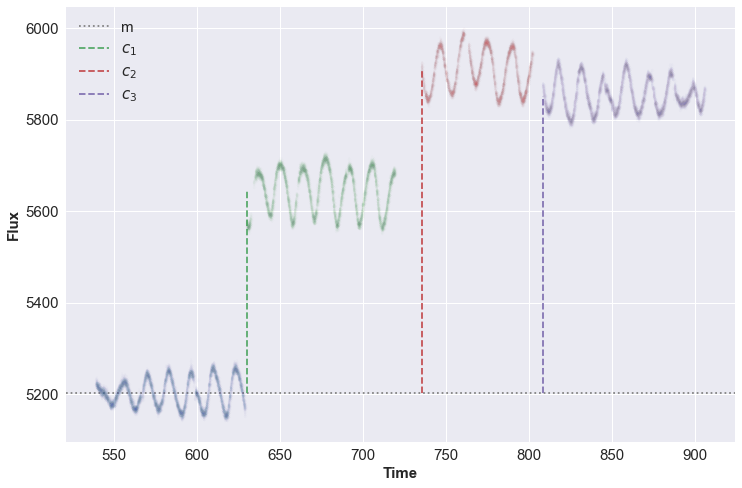

In [212]:
plt.figure(figsize = (12,8))
qs = sorted(np.unique(tab['quarter']))
means = []
cycle_map = {}
for i, q in enumerate(qs):
    ind = tab['quarter']==q
    t = tab[ind]
    plt.errorbar(t['time'],t['flux'], yerr=t['error'], marker='.', linestyle='None', alpha=0.01)
    meanflux = np.mean(t['flux'])
    cycle_map[q] = ind
    means.append(meanflux)
    if i == 0:
        plt.axhline(meanflux, label='m', color='grey', ls=":")
    else:

        vmin = means[0]
        vmax = meanflux

        plt.plot((t['time'][0], t['time'][0]), (vmin, vmax), label=rf'$c_{i}$', color=f'C{i}', ls='--') 


plt.xlabel('Time', weight = "bold", size = 15)
plt.ylabel('Flux', weight = "bold", size = 15)
plt.legend(frameon=False, prop = {"size":15})
plt.tick_params("both", labelsize = 15)

t, y, dy = tab["time"], tab["flux"], tab["error"]

### As you can see there is some kind of periodic signal, but it's not perfectly regular. There is also the usual offsets between Kepler photometry in different cycles.

### You'll need four parameters to describe constants ($m, c_1, c_2, c_3$) to renormalize the flux to the first cycle, illustrated in the figure above. 
### $m$ specifies the mean of the Gaussian process, while $c_1, c_2, c_3$ are nuisance parameters. 

### You know how to implement a model with one common zeropoint and multiple offsets - this was what you did on your midterm.


### You'll also need some model to describe the quasi-periodic oscillations. There's no good way to write down a model in real for these in real space because stellar magnetic fields are incredibly complicated. 

### Instead we'll write down a model for the covariance between the observations and use a Gaussian process to model the star. You can model quasi-periodic correlation structure as something periodic + something that varies the periodicity smoothly:

## $$k(t_i, t_j) = A\cdot \exp\left(-\Gamma_1\cdot \sin^2\left(\frac{\pi}{P}|t_i - t_j|\right) -  \frac{|t_i-t_j|^2}{\lambda}) \right) $$

### This is another 4 parameters, ($A, \Gamma_1, P, \lambda$) parameters for a total of 8: ($m, c_1, c_2, c_3, A, \Gamma_1, P, \lambda$)

<hr>

### Q1: To implement the GP correlations, use the `george` package to construct this quasi-periodic kernel
https://george.readthedocs.io/en/latest/user/kernels/


### In particular, you should be able to combine `ExpSine2Kernel` and `ExpSquaredKernel` to get a model for the quasi-periodic oscillations.

ExpSine2Kernel :  

>${k(\mathbf{x}_i,\,\mathbf{x}_j) =
        \exp \left( -\Gamma\,\sin^2\left[
            \frac{\pi}{P}\,\left|x_i-x_j\right|
        \right] \right)}$
        
ExpSquaredKernel : 

>${k(r^2) = \exp \left ( -\frac{r^2}{2} \right )}$

Kernel we want: 

>${A \cdot
        \exp \left( -\Gamma\,\sin^2\left[
            \frac{\pi}{P}\,\left|x_i-x_j\right|
        \right] \right) \cdot \exp \left ( -\frac{\left|x_i-x_j\right|^2}{2} \right ) = 
         A\cdot \exp\left(-\Gamma_1\cdot \sin^2\left(\frac{\pi}{P}|x_i - x_j|\right) -  \frac{|x_i-x_j|^2}{\lambda}) \right)}$

In [245]:
#I'm doing making the parameters random normal variables because I don't know what they are
#This is another 4 parameters (𝐴, Γ_1, 𝑃, 𝜆)
A_p, period_p = np.random.uniform(low = 1e-10), np.random.uniform(low = 1e-10)
gamma_p, lamdba_p = np.random.uniform(low = 1e-10), np.random.uniform(low = 1e-10)

# Create a kernel 
k = A_p * kernels.ExpSine2Kernel(gamma = gamma_p, log_period = period_p) * kernels.ExpSquaredKernel(metric = 2.)

### Q2: To implement the full model, read how to use `george`'s modeling protocol:
https://george.readthedocs.io/en/latest/tutorials/model/

In [246]:
#You need 4 parameters (𝑚,𝑐1,𝑐2,𝑐3) to renormalize the flux to the first cycle
class Model(Model):
    parameter_names = ("m", "c1", "c2", "c3")
    def get_value(self, t):
        t = t.flatten()
        return ({self.m, self.m + self.c1, self.m + self.c2,  self.m + self.c3})
    
gp = GP(mean = Model(means[0],means[1],means[2],means[3]), kernel= k)

def nll(p):
    gp.set_parameter_vector(p)
    ll = gp.log_likelihood(y[::20], quiet=True)
    return -ll if np.isfinite(ll) else 1e25

# And the gradient of the objective function.
def grad_nll(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(y[::20], quiet=True)


# You need to compute the GP once before starting the optimization.
gp.compute(t[::20], dy[::20])

### Q3: With your model and likelihood constructured, write down priors on the parameters (you should be able to estimate from the plots)

In [202]:
# define a mean model defined by the polynomial we just found
class Model(Model):
        parameter_names = ("m", "c1", "c2", "c3")

    def get_value(self, t):
        t = t.flatten()
        return (t * self.m + self.b +
                self.amp * np.exp(-0.5*(t-self.location)**2*np.exp(-self.log_sigma2)))

    
# now use the polynomial as the mean model - but we're not fitting those values again - just the GP parameters
gp = GP(mean=PolynomialModel(), kernel=k)


# Define the objective function (negative log-likelihood in this case).



# Run the optimization routine.
p0 = gp.get_parameter_vector()
results = scipy.optimize.minimize(nll, p0, jac=grad_nll, method="L-BFGS-B")

# Update the kernel and print the final log-likelihood.
gp.set_parameter_vector(results.x)

(560, 650)

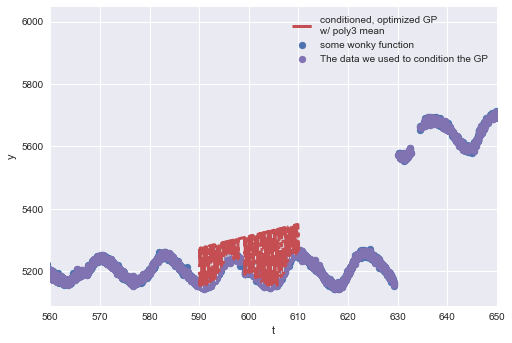

In [207]:
# now make a new prediction with our new mean model
ypred2, cov = gp.predict(y[::20], t_new, return_cov=True)
std = np.sqrt(np.diag(cov))

# plot the data
plt.scatter(t, y, color='C0', marker='o', label='some wonky function')
plt.scatter(t[::2], y[::2], color='C3', marker='o', label='The data we used to condition the GP')

# plot our initial prediction with a constant mean

# plot our new prediction with the polynomial mean 
plt.plot(t_new, ypred2, 'C2', ls='-.', label='conditioned, optimized GP\nw/ poly3 mean', lw=3)

# plot the scatter about the posterior predictive mean from the diagonal of the covariance matrix 
plt.fill_between(t_new, ypred2-std, ypred2+std, color='lightgrey')


plt.legend(frameon=False)
plt.xlabel('t')
plt.ylabel('y');
plt.xlim(560,650)

### Q4: Use `emcee` to optimize the model parameters and hyper-parameters, **using only every 10th sample in time**
### (Don't go overboard with the number of walkers or steps)
https://george.readthedocs.io/en/latest/tutorials/hyper/ may help

In [116]:
ypred2, cov = gp.predict(t["flux"][::2], t_new, return_cov=True)
std = np.sqrt(np.diag(cov))


ValueError: Dimension mismatch

### Q5: Plot your posterior model over the data after correcting for the offsets, showing the points you used to condition the GP in red, and the remaining data in black. 